In [1]:
import collections
import glob
import json
import seaborn as sns

In [2]:
def blerp(obj):
    counter = collections.Counter()
    for label in obj["reviewlabels"]:
        if label["merge-with-prior"]:
            continue
        counter[label["labels"]["coarse"]] += 1
        counter[label["labels"]["asp"]] += 1
    for label in obj["rebuttallabels"]:
        counter[label["labels"]["coarseresponse"]] += 1
    return counter    

In [3]:
dataset_path = "/Users/nnayak/Downloads/0517_split_2/"

results = collections.OrderedDict()

for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    subset_counter = collections.Counter()
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            subset_counter += blerp(train_obj)
    results[subset] = subset_counter

In [4]:
import numpy as np
import matplotlib.pyplot as plt


category_colors = plt.get_cmap('Pastel2')

reb_category_names = "concur dispute nonarg".split()
rev_category_names = "Structuring Evaluative Request Fact Social Other".split()
asp_category_names = ("Originality|Meaningful Comparison|Soundness/Correctness|"
                      "Substance|Clarity|Motivation/Impact|Replicability").split("|")

hatches = "xx O // o ++ . \\".split()

def survey(results, category_names, ax, normalize=False):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    labels = []
    data = []
    for label, value_map in results.items():
        labels.append(label)
        data.append([value_map[cat_name] for cat_name in category_names])
    normalized_data = [[1000 * i/sum(l) for i in l] for l in data]
    
    data = np.array(data)
    data_cum = data.cumsum(axis=1)
    normalized_data = np.array(normalized_data)
    normalized_data_cum = normalized_data.cumsum(axis=1)
    
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    if normalize:
        ax.set_xlim(0, np.sum(normalized_data, axis=1).max())
    else:
        ax.set_xlim(0, np.sum(data, axis=1).max())
    
    for i, colname in enumerate(category_names):
    
        if normalize:
            widths = normalized_data[:, i]
            starts = normalized_data_cum[:, i] - widths
        else:
            widths = data[:, i]
            starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=category_colors(i), edgecolor='k', hatch=hatches[i])

    ax.legend(
        bbox_to_anchor=(0, -0.35, 1.0, 1.0),
        loc='lower center', borderaxespad=0., ncol=2, fontsize='large')

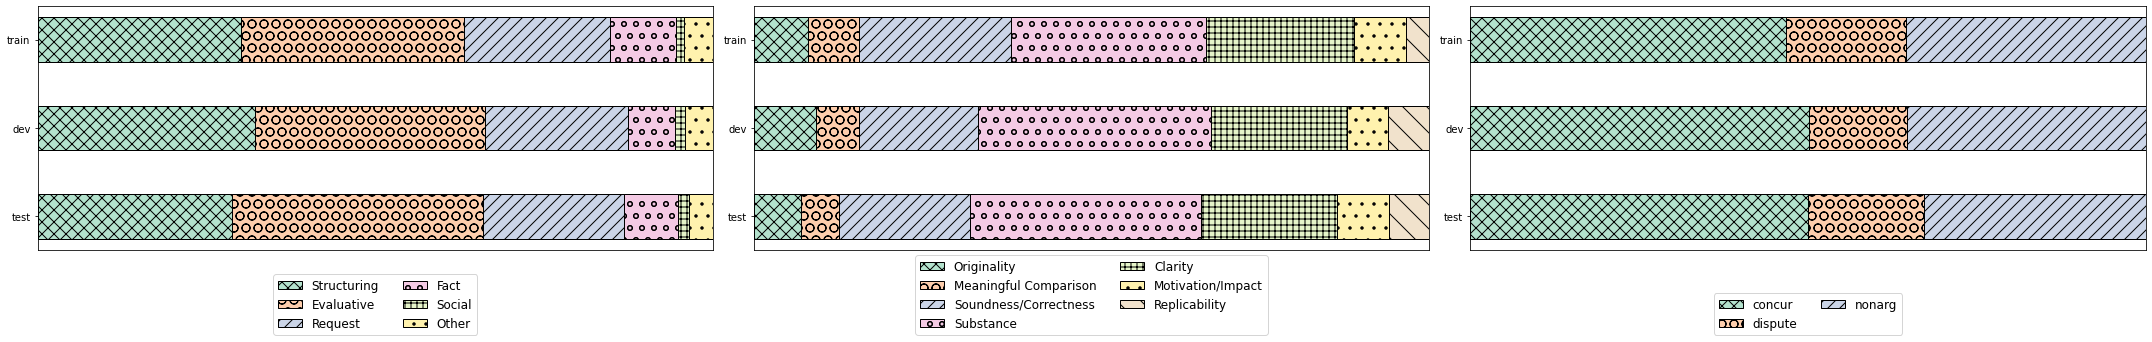

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
survey(results, rev_category_names, ax1, True)
survey(results, asp_category_names, ax2, True)
survey(results, reb_category_names, ax3, True)
plt.tight_layout()
plt.savefig('dists.pdf')

In [6]:
# Agreeability
# For each example, list the ratio of concur v/s dispute as well as the rating

In [7]:
coarse_responses = "concur dispute nonarg".split()
Example = collections.namedtuple("Example", ["rating", "agreeableness"])


subset_dir = dataset_path + "train/*"
examples = collections.defaultdict(list)

def get_agreeableness(stance_counter):
    return stance_counter["concur"] / (stance_counter["concur"] + stance_counter["dispute"] + 1)

for filename in glob.glob(subset_dir):
    with open(filename, 'r') as f:
        train_obj = json.load(f)
        forum = train_obj['metadata']['forum_id']
        rating = int(train_obj['metadata']['rating'].split(':')[0])
        stance_counter = collections.Counter()
        for label in train_obj["rebuttallabels"]:
            stance_counter[label['labels']['coarseresponse']] += 1
        examples[forum].append(Example(rating, get_agreeableness(stance_counter)))

ForumExample = collections.namedtuple("ForumExample", "index forum rating agreeableness".split())
forum_examples = []        
forum_variability_map = {}
for k, v in examples.items():
    if len(v) == 3:
        for comment in v:
            forum_examples.append((k, comment.rating, comment.agreeableness))
        forum_variability_map[k] = np.var([x.agreeableness for x in v])
    
# Reorder forums

forum_order = {forum:i for i, (forum, _) in enumerate(sorted(forum_variability_map.items(), key=lambda x:x[1]))}

examples_for_df = []
for (forum, rating, agg) in forum_examples:
    examples_for_df.append(ForumExample(forum_order[forum], forum, rating, agg))


In [8]:
import pandas as pd

df = pd.DataFrame.from_dict(examples_for_df)

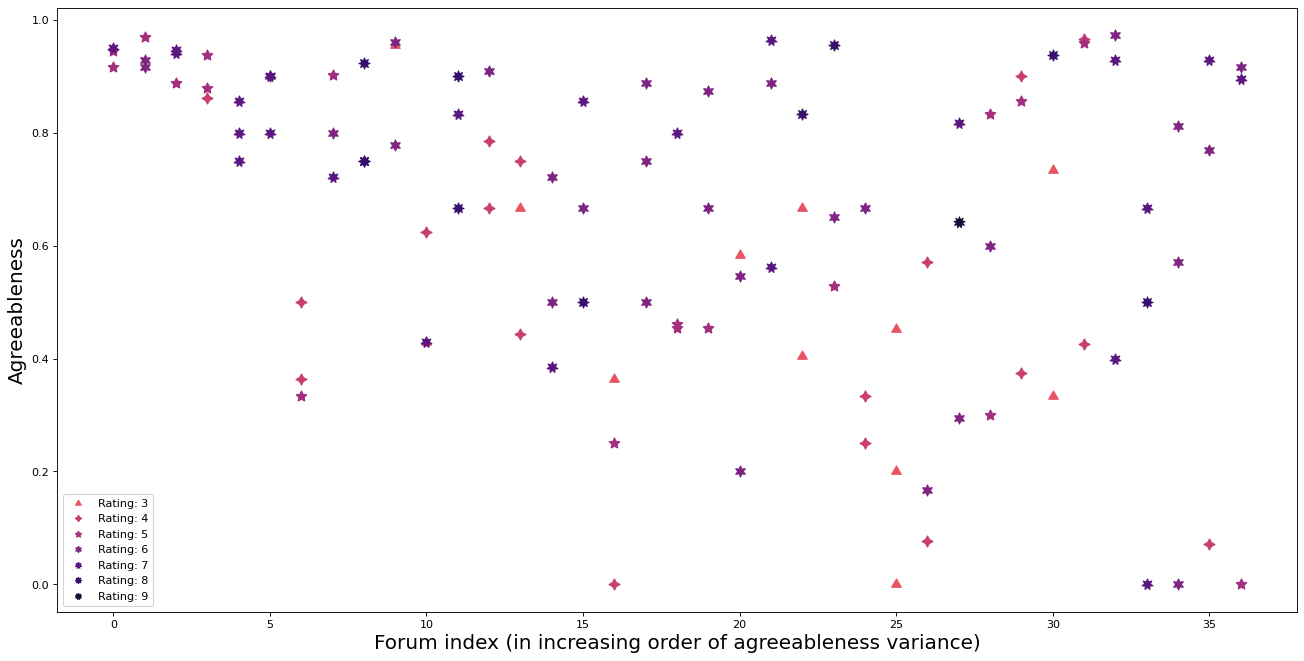

In [9]:
#from matplotlib.pyplot import figure

from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
colors = plt.get_cmap('magma_r')(np.linspace(0.1, 0.9, 10))
custom_markers = []
legend_words = []
for rating in range(3, 10):
    newdf = df[(df.rating == rating)]
    plt.scatter(data=newdf, x="index", y="agreeableness", s=100, color=colors[rating], marker=(rating, 1, 0))
    custom_markers.append(Line2D([0], [0], marker=(rating, 1, 0), color=colors[rating], lw=0))
    legend_words.append("Rating: {0}".format(rating))
                          

ax.set_xlabel('Forum index (in increasing order of agreeableness variance)', fontsize=18)
ax.set_ylabel('Agreeableness', fontsize=18)
ax.legend(custom_markers, legend_words)

In [10]:
plt.savefig('agreeability.png')

<Figure size 432x288 with 0 Axes>

In [11]:
# Maybe just write a readme for the whole dataset?
# What do people need to know?

What are the things people want to know
* How many forums
* How many reviews in each forum. How many are double annotated. How long are they (in sentences). How long is each rebuttal (in sentences)
* Plot with two plots on either side?
* Split out ratings?

* How to interpret no-pol v/s neutral-pol? how do these split v/s arg type

* How many rebuttal sentences are mapped to something? How many review sentences are mapped to nothing?

* Check for integrity of chunks

In [12]:
examples = []
length_comparison_info = []
LengthExample = collections.namedtuple("LengthExample",
                                       "review_length rebuttal_length rating".split())
for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            forum = train_obj['metadata']['forum_id']
            examples.append(
                LengthExample(len(train_obj['review']),
                              len(train_obj['rebuttal'])/len(train_obj['review']),
                             int(train_obj['metadata']['rating'].split(':')[0]))._asdict()
            )

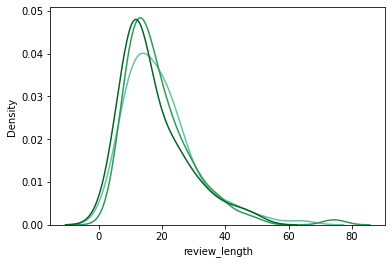

In [13]:
import seaborn as sns
df = pd.DataFrame.from_dict(examples)


colors = plt.get_cmap('BuGn')(np.linspace(0.5, 0.9, 3))
bins = [[3, 4], [5,6,7], [8,9,10]]

for i, which_bin in enumerate(bins):
    newdf = df[(df["rating"].isin(which_bin))]
    sns.kdeplot(data=newdf, x="review_length",
                color=colors[i],
               )

In [14]:
reply_pairs = []

for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            for rebuttal_label in train_obj["rebuttallabels"]:
                for aligned_review_i in rebuttal_label["labels"]["alignments"]:
                    reply_pairs.append((rebuttal_label["labels"]["responsetype"],
                                        train_obj["reviewlabels"][aligned_review_i]["labels"]["coarse"]))
c = collections.Counter(reply_pairs)


In [15]:
fields = "subset forum rev_idx sent coarse fine asp pol merge".split()
RevSentLine = collections.namedtuple("RevSentLine", fields)
lines = []
for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            forum = train_obj["metadata"]["forum_id"]
            for sent, label in zip(train_obj["review"], train_obj["reviewlabels"]):
                lines.append(RevSentLine(
                    subset, forum, label["sid"],
                    sent["sentence"],
                label["labels"]["coarse"],
                label["labels"]["fine"],
                label["labels"]["asp"],
                label["labels"]["pol"],
                label["merge-with-prior"]
                )._asdict())
import csv

with open('review_sentences.csv', 'w') as f:
    w = csv.DictWriter(f, fields, delimiter='\t')
    w.writeheader()
    for row in lines:
        w.writerow(row)
    


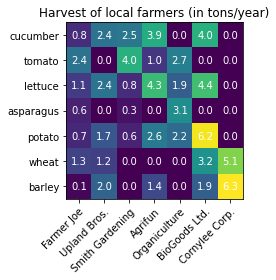

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

label_checkers = collections.defaultdict(lambda:collections.Counter())
for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            forum = train_obj["metadata"]["forum_id"]
            
            for sent, label in zip(train_obj["review"], train_obj["reviewlabels"]):
                for label_type in "fine asp pol".split():
                    label_checkers[label["labels"]["coarse"]][label_type]
                lines.append(RevSentLine(
                    subset, forum, label["sid"],
                    sent["sentence"],
                label["labels"]["coarse"],
                label["labels"]["fine"],
                label["labels"]["asp"],
                label["labels"]["pol"],
                label["merge-with-prior"]
                )._asdict())

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [17]:
print(results)

OrderedDict([('train', Counter({'concur': 2134, '': 1689, 'nonarg': 1625, 'Evaluative': 1263, 'Structuring': 1149, 'Request': 824, 'dispute': 811, 'Substance': 590, 'Soundness/Correctness': 460, 'Clarity': 447, 'Fact': 374, 'Other': 164, 'Originality': 163, 'Motivation/Impact': 155, 'Meaningful Comparison': 154, 'Replicability': 71, 'Social': 43})), ('dev', Counter({'concur': 802, 'nonarg': 566, '': 418, 'Evaluative': 330, 'Structuring': 312, 'dispute': 233, 'Request': 205, 'Substance': 179, 'Clarity': 105, 'Soundness/Correctness': 91, 'Fact': 68, 'Originality': 48, 'Other': 40, 'Meaningful Comparison': 33, 'Replicability': 32, 'Motivation/Impact': 31, 'Social': 14})), ('test', Counter({'concur': 1672, '': 1181, 'nonarg': 1099, 'Evaluative': 1066, 'Structuring': 825, 'Request': 597, 'dispute': 575, 'Substance': 560, 'Clarity': 329, 'Soundness/Correctness': 317, 'Fact': 229, 'Motivation/Impact': 125, 'Originality': 114, 'Other': 101, 'Replicability': 98, 'Meaningful Comparison': 92, 'So

In [18]:
for k, v in results["train"].items():
    print(k)
    print(v)

Structuring
1149

1689
Evaluative
1263
Substance
590
Request
824
Soundness/Correctness
460
Replicability
71
Fact
374
nonarg
1625
concur
2134
dispute
811
Other
164
Motivation/Impact
155
Clarity
447
Originality
163
Meaningful Comparison
154
Social
43


In [19]:
dir_globber = "/Users/nnayak/Downloads/0517_split_2/train/*"

def review_getter(obj):
    my_counter = collections.Counter()
    for sent in obj["reviewlabels"]:
        my_counter[sent["labels"]["coarse"]] += 1
        my_counter[sent["labels"]["fine"]] += 1
        if sent["labels"]["asp"]:
            my_counter[sent["labels"]["asp"]] += 1
    return my_counter

results = collections.Counter()
review_counter = collections.Counter()
for filename in glob.glob(dir_globber):
    with open(filename, 'r') as f:
        train_obj = json.load(f)
        results += review_getter(train_obj)


In [20]:
results

Counter({'Structuring': 1209,
         'Structuring.Summary': 809,
         'Evaluative': 2712,
         'Substance': 648,
         'Request': 902,
         'Request.Explanation': 272,
         'Soundness/Correctness': 502,
         'Replicability': 80,
         'Request.Edit': 219,
         'Fact': 782,
         'Request.Experiment': 216,
         'Structuring.Heading': 347,
         'Other': 342,
         'Motivation/Impact': 155,
         'Request.Clarification': 112,
         'Clarity': 496,
         'Originality': 172,
         'Meaningful Comparison': 158,
         'Request.Typo': 83,
         'Social': 86,
         'Structuring.Quote': 53})

In [21]:
b = collections.OrderedDict([
    ("Request", "Request Request.Typo Request.Edit Request.Clarification Request.Experiment Request.Explanation".split()),
    ("Evaluative", "Evaluative|Clarity|Meaningful Comparison|Motivation/Impact|Originality|Replicability|Soundness/Correctness|Substance".split("|")),
    ("Structuring", "Structuring Structuring.Heading Structuring.Quote Structuring.Summary".split()),
    ("Social", ["Social"]),
    ("Fact", ["Fact"]),
    ("Other", ["Other"] ),
])

In [22]:
dicts = []
for i, (coarse, fines) in enumerate(b.items()):
    for fine in fines:
        dicts.append({
            "coarse": coarse,
            "fine": fine.split(".")[-1],
            "ct": results[fine]
        })
    
    dicts.append({
        "coarse": "",
        "fine": " " * i,
        "ct": 0
    })
        
d = pd.DataFrame.from_dict(dicts)


In [23]:
muted_palette = sns.color_palette('muted')
dark_palette = sns.color_palette('dark')
num_repeats = [7,9,5,2,2,2]

my_palette = sum([[dark_palette[i]] + [muted_palette[i]] * (num-1) for i, num in enumerate(num_repeats)], [])

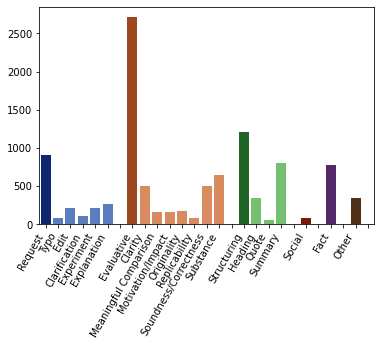

In [24]:
rev_cats = sns.barplot(x=np.array(d.fine), y=np.array(d.ct), palette=my_palette)
_ = plt.xticks(rotation=60, ha='right')


In [25]:
dataset_path = "/Users/nnayak/Downloads/0517_split_2/"

source_counter = collections.defaultdict(lambda: collections.Counter())

for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    subset_counter = collections.Counter()
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            if train_obj['metadata']['anno'] == 'anno0' and not subset == 'train':
                final_subset = subset + "_adjudicated"
            else:
                final_subset = subset
            source_counter[final_subset][train_obj["metadata"]['conference']] += 1
            
print(source_counter)

defaultdict(<function <lambda> at 0x133a56550>, {'train': Counter({'ICLR2019': 138, 'ICLR2020': 71}), 'dev': Counter({'ICLR2019': 38, 'ICLR2020': 31}), 'test_adjudicated': Counter({'ICLR2019': 54, 'ICLR2020': 10}), 'test': Counter({'ICLR2020': 53, 'ICLR2019': 49})})


In [26]:
dicts = []

for subset, v in source_counter.items():
    for conference, count in v.items():
        dicts.append({
            "subset": subset.split('_')[0],
            "conference": conference,
            "total": count,
            "adjudicated": 'Y' if 'adjudicated' in subset else 'N',
        })
    
f = pd.DataFrame.from_dict(dicts)

In [27]:
pd.pivot_table(f, index='conference', columns=['subset', 'adjudicated'], values='total',aggfunc=np.sum)

subset      dev test     train
adjudicated   N    N   Y     N
conference                    
ICLR2019     38   49  54   138
ICLR2020     31   53  10    71

In [28]:
f

,subset,conference,total,adjudicated
0,train,ICLR2020,71,N
1,train,ICLR2019,138,N
2,dev,ICLR2020,31,N
3,dev,ICLR2019,38,N
4,test,ICLR2020,10,Y
5,test,ICLR2019,54,Y
6,test,ICLR2020,53,N
7,test,ICLR2019,49,N


In [29]:
import openreview

guest_client = openreview.Client(baseurl='https://api.openreview.net')

def get_num_reviews(guest_client, forum_id):
    forum_notes = guest_client.get_notes(forum=forum_id)
    review_count = 0
    for note in forum_notes:
        if note.replyto == forum_id and 'Reviewer' in note.signatures[0]:
            review_count += 1
    return review_count

dataset_path = "/Users/nnayak/Downloads/0517_split_2/"

source_counter = collections.defaultdict(
    lambda: collections.defaultdict(list))

for subset in "train dev test".split():
    subset_dir = dataset_path + subset + "/*"
    subset_counter = collections.Counter()
    for filename in glob.glob(subset_dir):
        with open(filename, 'r') as f:
            train_obj = json.load(f)
            key = (train_obj['metadata']['forum_id']
                ,train_obj['metadata']['conference'])
            source_counter[subset][key].append(
            train_obj['metadata']['review'])
dicts = []            
for subset, examples in source_counter.items():
    print(subset)
    print(len(examples))
#     for (forum, conference), reviews in examples.items():
#         dicts.append(
#         {"forum": forum,
#          "subset": subset,
#          "conference": conference,
#          "annotated_reviews": len(reviews),
#          "total_reviews":  get_num_reviews(guest_client, forum)})
        


train
95
dev
37
test
57


In [30]:
df = pd.DataFrame.from_dict(dicts)
df["unannotated"] = df.total_reviews - df.annotated_reviews
df2 = df.sort_values(by=["subset", 'unannotated'])

AttributeError: 'DataFrame' object has no attribute 'total_reviews'

In [ ]:
df2.plot.bar(stacked=True, x="forum", y=["annotated_reviews", "unannotated"])

In [ ]:
len(df2)

In [ ]:
df2.sum()